<a href="https://colab.research.google.com/github/BenjamTorr/TDA_DeepL_TimeSeries/blob/main/ECG_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U giotto-tda

  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [142]:
from scipy.interpolate import interp1d
import pandas as pd
from scipy.io import arff
import pandas as pd
import numpy as np
def load():
  clase = [1,1,0]
  data_train = arff.loadarff('drive/MyDrive/Data-Time_Series/ECG200_TRAIN.arff')
  df_train = pd.DataFrame(data_train[0])

  x_train = df_train.to_numpy()
  y_train = x_train[:,-1]
  y_train = [clase[int(y_train[i].decode('utf-8'))] for i in range(len(y_train))]
  y_train = np.transpose(np.array(y_train))

  data_test = arff.loadarff('drive/MyDrive/Data-Time_Series/ECG200_TEST.arff')
  df_test = pd.DataFrame(data_test[0])
  x_test = df_test.to_numpy()
  y_test = x_test[:,-1]
  

  y_test = [clase[int(y_test[i].decode('utf-8'))]  for i in range(len(y_test))]
  y_test = np.transpose(np.array(y_test))
  x_test[1,:-1]
  interval = np.arange(0, 95, step=0.15)
  X_test = [interp1d(range(96),x_test[i,:-1], kind="cubic")(interval) for i in range(len(x_test))]
  X_train = [interp1d(range(96),x_train[i,:-1], kind="cubic")(interval) for i in range(len(x_train))]
  return X_train, y_train, X_test, y_test

In [143]:
import gtda
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve


def get_betti_seq(X_train, X_test, bins = 100):
  TE = TakensEmbedding(time_delay=1, dimension=3)
  Embd_train = TE.fit_transform(X_train)
  Embd_test = TE.fit_transform(X_test)

  VR_train = VietorisRipsPersistence(homology_dimensions=(0,1), max_edge_length=1, n_jobs = -1)
  Xt = VR_train.fit_transform(Embd_train)
  VR_test = VietorisRipsPersistence(homology_dimensions=(0,1), max_edge_length=1, n_jobs = -1)
  Xtr = VR_test.fit_transform(Embd_test)

  BC_train = BettiCurve(n_bins = bins)
  X_betti_curves_train = BC_train.fit_transform(Xt)
  BC_test = BettiCurve(n_bins = bins)
  X_betti_curves_test = BC_test.fit_transform(Xtr)

  X_betti_seq_train = [np.concatenate([X_betti_curves_train[i,0], X_betti_curves_train[i,1]]) for i in range(len(X_betti_curves_train))]
  X_betti_seq_test = [np.concatenate([X_betti_curves_test[i,0], X_betti_curves_test[i,1]]) for i in range(len(X_betti_curves_test))]

  return X_betti_seq_train, X_betti_seq_test, Xt, Xtr

In [124]:
X_train, y_train, X_test, y_test = load()

In [144]:
X_betti_seq_train, X_betti_seq_test, Xt, Xtr = get_betti_seq(X_train, X_test, bins = 500)

In [145]:
BC = BettiCurve(n_bins = 500)
X_bt = BC.fit_transform(Xt)
X_btr = BC.fit_transform(Xtr)

In [146]:
BC.plot(X_bt, sample=45)

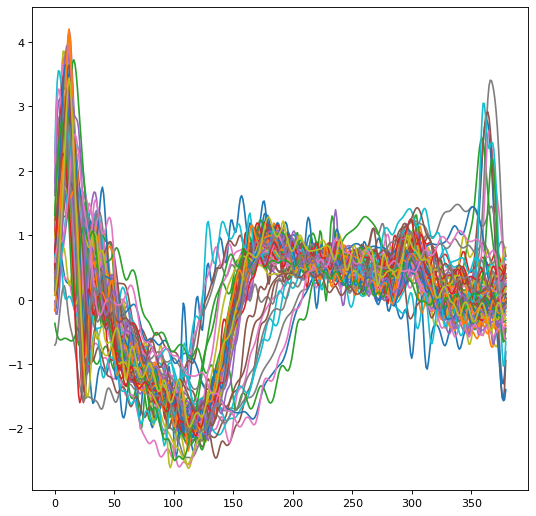

In [147]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

for y in range(len(y_train)):
  if y_train[y] == 1:
    plt.plot(X_train[y])
plt.show()

96

In [148]:
samples_test = np.zeros(2)
samples_train = np.zeros(2)
for i in range(len(y_test)):
  samples_test[y_test[i]] += 1
for i in range(len(y_train)):
  samples_train[y_train[i]] += 1

print(samples_test)
print(samples_train) 

[36. 64.]
[31. 69.]


In [235]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
def evaluar_modelo(X_betti_seq_train, y_train, X_betti_seq_test, y_test, X_betti_seq_val, y_val, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(64, 9, activation="relu", padding="valid", input_shape=(1000, 1)),
      keras.layers.Conv1D(32, 7, activation="relu", padding="same"),
      keras.layers.Dropout(0.5),
      keras.layers.AveragePooling1D(10),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dense(64, activation="relu"),
      keras.layers.Dense(2, activation="softmax")
  ])
  opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
  opt2 = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(loss = "categorical_crossentropy", optimizer=opt2, metrics=["accuracy"])
  class_weight = {0: 1.61290323, 1: 0.72463768}
  history = model.fit(X_betti_seq_train, y_train, epochs=30, validation_data=(X_betti_seq_val, y_val), verbose = verbose1, class_weight=class_weight)
  a,acc = model.evaluate(X_betti_seq_test, y_test)
  return history, acc, model

In [150]:
y_test_1h = keras.utils.to_categorical(y_test[10:])
y_train_1h = keras.utils.to_categorical(y_train[10:])
y_val = np.concatenate([y_test[:10], y_train[:10]])
y_val_1h = keras.utils.to_categorical(y_val)
X_betti_seq_val = X_betti_seq_test[:10]
X_betti_seq_valP = np.concatenate([X_betti_seq_val, X_betti_seq_train[:10]])
X_betti_seq_testR = np.expand_dims(X_betti_seq_test[10:],axis=-1)
X_betti_seq_trainR = np.expand_dims(X_betti_seq_train[10:],axis=-1)
X_betti_seq_valR = np.expand_dims(X_betti_seq_valP, axis=-1)

In [151]:
def score(itr):
  scores = np.zeros(itr)
  for i in range(itr):
    history, acc, model = evaluar_modelo( X_betti_seq_trainR, y_train_1h, X_betti_seq_testR, y_test_1h, X_betti_seq_valR, y_val_1h, 0)
    scores[i] = acc
  m = np.mean(scores)
  s = np.std(scores)
  return m,s

In [ ]:
m, s = score(10)
print([m,s])

In [233]:
history, acc, model = evaluar_modelo( X_betti_seq_trainR, y_train_1h, X_betti_seq_testR, y_test_1h, X_betti_seq_valR, y_val_1h, 1)

Epoch 1/30
3/3 [==============================] - 1s 251ms/step - loss: 1.2204 - accuracy: 0.6111 - val_loss: 0.6715 - val_accuracy: 0.5500
Epoch 2/30
3/3 [==============================] - 0s 144ms/step - loss: 0.6882 - accuracy: 0.5111 - val_loss: 0.4551 - val_accuracy: 0.8500
Epoch 3/30
3/3 [==============================] - 0s 150ms/step - loss: 0.6275 - accuracy: 0.6667 - val_loss: 0.4328 - val_accuracy: 0.8500
Epoch 4/30
3/3 [==============================] - 0s 147ms/step - loss: 0.5846 - accuracy: 0.6556 - val_loss: 0.5614 - val_accuracy: 0.7000
Epoch 5/30
3/3 [==============================] - 0s 150ms/step - loss: 0.5338 - accuracy: 0.7111 - val_loss: 0.4360 - val_accuracy: 0.8500
Epoch 6/30
3/3 [==============================] - 0s 147ms/step - loss: 0.5387 - accuracy: 0.8000 - val_loss: 0.4181 - val_accuracy: 0.8500
Epoch 7/30
3/3 [==============================] - 0s 147ms/step - loss: 0.4956 - accuracy: 0.8222 - val_loss: 0.5298 - val_accuracy: 0.7500
Epoch 8/30
3/3 [====

<function matplotlib.pyplot.show>

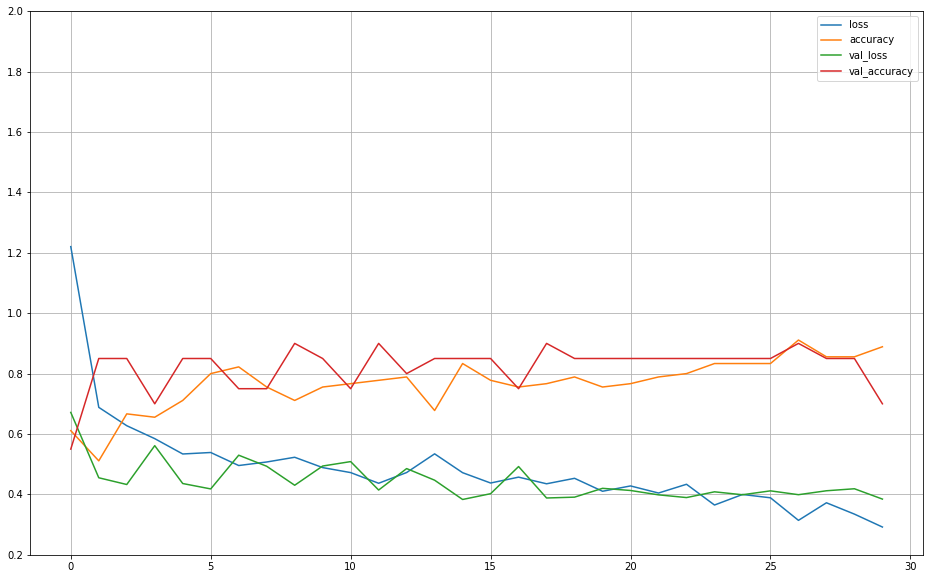

In [234]:
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0.2,2)
plt.show

In [223]:
y_pred = model.predict(X_betti_seq_testR)

import plotly.express as px

CM = tf.math.confusion_matrix(y_pred.argmax(axis=1), y_test_1h.argmax(axis=1))

fig = px.imshow(CM, color_continuous_scale="inferno")
fig.show()

In [224]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1h.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78        34
           1       0.86      0.88      0.87        56

    accuracy                           0.83        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.83      0.83      0.83        90



In [57]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

array([1.61290323, 0.72463768])